In [1]:
import SimpleITK as sitk
import numpy as np
from loader import ReadSliceDataList, ImportImage, getInputShape, Affine, Transforming, makeAffineParameters, GetMinimumValue

In [2]:
def GenerateBatchData(dataList, apply_augmentation=False, num_class=3, batch_size = 32):
    while True:
        indices = list(range(len(dataList)))
        random.shuffle(indices)

        if apply_augmentation:
            for i in range(0, len(indices), batch_size):
                imageLabelList = np.array([ImportTransformedImage(dataList[idx][0]) for idx in indices[i : i + batch_size]])

                imageList, labelList = zip(*imageLabelList)
                
                onehotLabelList = tf.keras.utils.to_categorical(labelList, num_classes=num_class)

                yield (imageList, onehotLabelList)

        else:
            for i in range(0, len(indices), batch_size):
                imageList = np.array([ImportImage(dataList[idx][0]) for idx in indices[i : i + batch_size]])

                onehotLabelList = np.array([tf.keras.utils.to_categorical(ImportImage(dataList[idx][1], num_classes=num_class)) for idx in indices[i : i + batch_size]])

                yield (imageList, onehotLabelList)

In [7]:
def ImportTransformedImage(imageFile, labelFile):
    sigma = 0
    translationrange = 0 # [mm]
    rotrange = 15 # [deg]
    shearrange = 0
    scalerange = 0.05
    bspline = None
    
    image = sitk.ReadImage(imageFile)
    label = sitk.ReadImage(labelFile)
    
    parameters = makeAffineParameters(image, translationrange, rotrange, shearrange, scalerange)
    affine = Affine(*parameters)

    imageMinVal = GetMinimumValue(image)
    labelMinVal = GetMinimumValue(label)

    transformedImage = Transforming(image, bspline, affine, sitk.sitkLinear, imageMinVal)
    transformedLabel = Transforming(label, bspline, affine, sitk.sitkNearestNeighbor, labelMinVal)

    imageArray = sitk.GetArrayFromImage(transformedImage)
    labelArray = sitk.GetArrayFromImage(transformedLabel)
    
    if image.GetNumberOfComponentsPerPixel() == 1:
        imageArray = imageArray[..., np.newaxis]

    if label.GetNumberOfComponentsPerPixel() == 1:
        labelArray = labelArray[..., np.newaxis]
    
    return (imageArray, labelArray)



In [9]:
imageLabelArray = ImportTransformedImage("/Users/tanimotoryou/Documents/lab/kidney/3Dkidney/test/case_00000/image/case_00000/image_0_12.mha", 
                       "/Users/tanimotoryou/Documents/lab/kidney/3Dkidney/test/case_00000/image/case_00000/label_0_12.mha")

In [11]:
from matplotlib import pyplot as plt

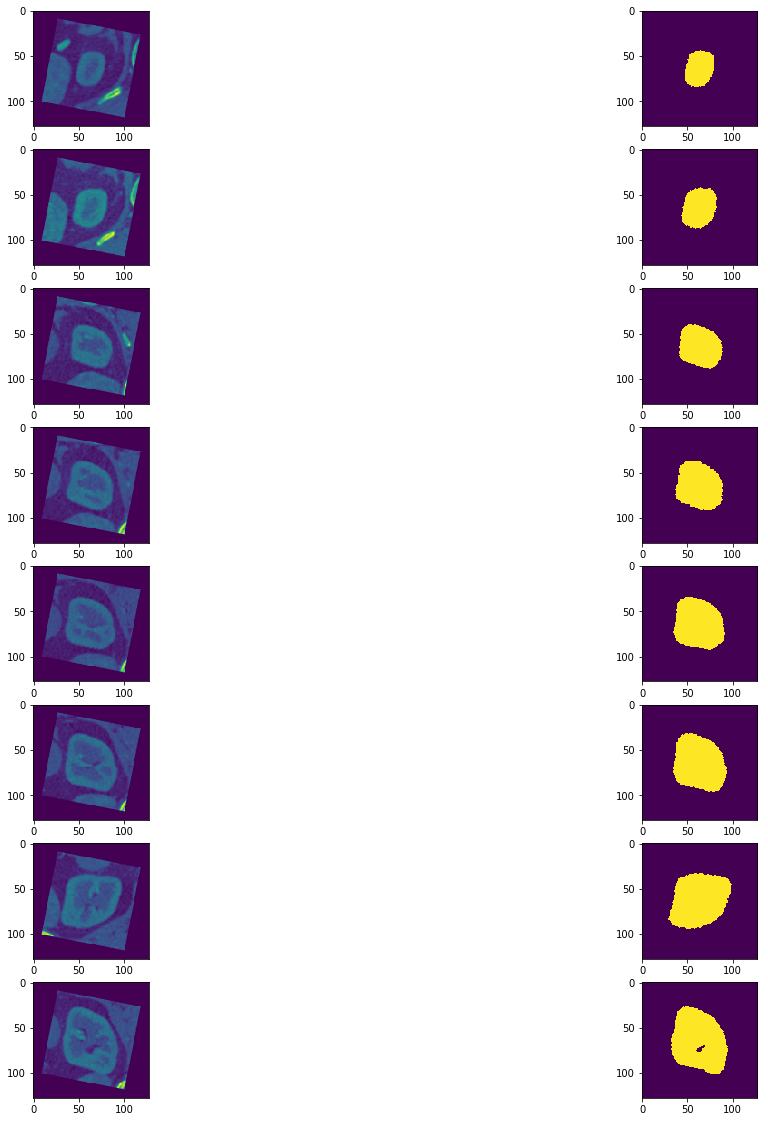

In [31]:
fig, axes = plt.subplots(8, 2, figsize=(20, 20))
for i in range(2):
    for x in range(imageLabelArray[0].shape[2]):
        img = imageLabelArray[i][:, :, x, :]
        axes[x][i].imshow(img.reshape(img.shape[:2]))